Loading All Required Libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


Step 1: Load and Explore the Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('weatherAUS.csv')  # Replace with the actual dataset path

# Display basic info and head
print(df.info())
print(df.head())

# Check for missing values
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Step 2: Feature Engineering and Cleaning === date to datetime  &  convert month to seasons according to month

fill missing values with median (if numeric)

fill missing value with mode (if categorical)

drop unnecessary column and old column with new column

In [2]:
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Example: Extract Season
def date_to_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    else:
        return 'Spring'

df['Season'] = df['Date'].apply(date_to_season)

# Drop columns that are not needed
df = df.drop(columns=['Date', 'Location'])  # Example

# Fill missing numeric values with median
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Fill missing categorical values with mode
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

df.head()


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Season
0,13.4,22.9,0.6,4.8,8.4,W,44.0,W,WNW,20.0,...,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,No,No,Summer
1,7.4,25.1,0.0,4.8,8.4,WNW,44.0,NNW,WSW,4.0,...,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,No,No,Summer
2,12.9,25.7,0.0,4.8,8.4,WSW,46.0,W,WSW,19.0,...,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,No,No,Summer
3,9.2,28.0,0.0,4.8,8.4,NE,24.0,SE,E,11.0,...,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,No,No,Summer
4,17.5,32.3,1.0,4.8,8.4,W,41.0,ENE,NW,7.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,Summer


Step 3: Define Features and Target 

here x is denoting all clumn of dataset

y is the column we want to predict

In [3]:
X = df.drop(columns='RainTomorrow')  # Features
y = df['RainTomorrow']               # Target


Step 4: Check Class Balance

watching output balance 

here is imbalance data no>>>yes

RainTomorrow
No     113583
Yes     31877
Name: count, dtype: int64


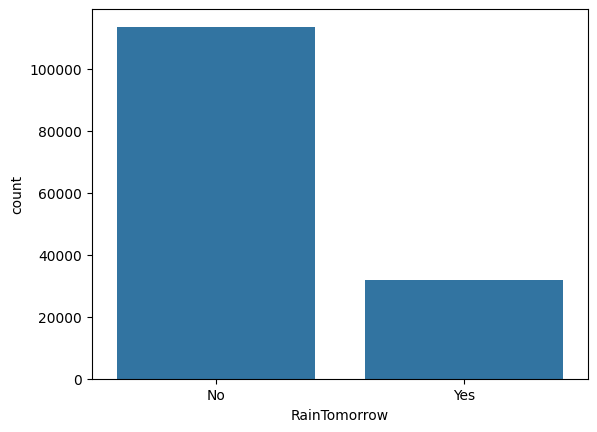

In [4]:
print(y.value_counts())
sns.countplot(x=y)
plt.show()


Step 5: Split Data into Train/Test Sets

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


Step 6: Identify Numeric and Categorical Features

Numeric = Scaling

Categorical = OHE

In [17]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
Categorical features: ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'Season']


Step 7: Preprocessing Transformers

In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


Step 8: Build Pipeline with RandomForest

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


Step 9: GridSearchCV for Hyperparameter Tuning

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    pipeline, param_grid, cv=5, scoring='accuracy', verbose=2
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END classifier__class_weight=None, classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   6.8s
[CV] END classifier__class_weight=None, classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   6.9s
[CV] END classifier__class_weight=None, classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   6.9s
[CV] END classifier__class_weight=None, classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   6.5s
[CV] END classifier__class_weight=None, classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   6.6s
[CV] END classifier__class_weight=None, classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  13.2s
[CV] END classifier__class_weight=None, cla

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Rainfall',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pressure3pm',
                                                                          'Cloud9am',
                                                                          'Cloud3pm',
                                                                          'Temp9am',
                                                                          'Temp3pm']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm',
                                                                          'RainToday',
                                                                          'Season'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__class_weight': [None, 'balanced'],
                         'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring='accuracy', verbose=2)

Step 10: Display Model Score

In [10]:
test_score = grid_search.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))


Test set score: 0.86


Step 11: Make Predictions

In [11]:
y_pred = grid_search.predict(X_test)


Step 12: Classification Report

In [12]:
from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

          No       0.87      0.96      0.91     22717
         Yes       0.76      0.50      0.60      6375

    accuracy                           0.86     29092
   macro avg       0.81      0.73      0.76     29092
weighted avg       0.85      0.86      0.84     29092



Step 13: Confusion Matrix

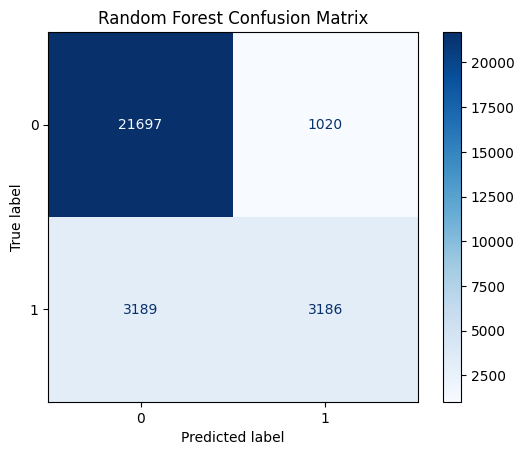

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()


Step 14: Feature Importances

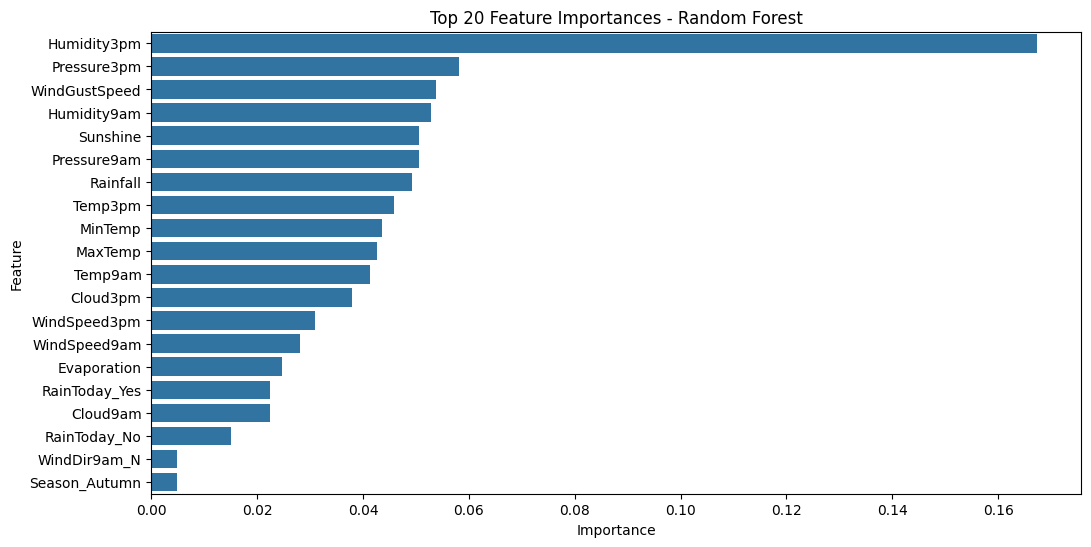

In [14]:
feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

# Combine with feature names
feature_names = numeric_features + list(grid_search.best_estimator_['preprocessor'].named_transformers_['cat'].get_feature_names_out())
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances - Random Forest')
plt.show()


Step 15: Update Pipeline with Logistic Regression

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   6.2s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   5.8s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   6.2s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   8.7s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   8.5s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.9s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.9s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.9s
[CV] END classifier__class_weight=No

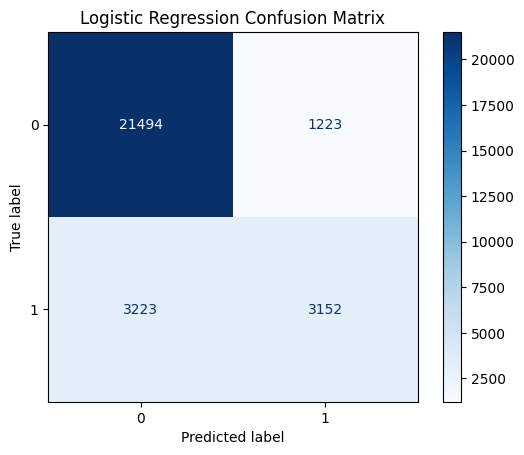

In [15]:
from sklearn.linear_model import LogisticRegression

# Replace classifier
pipeline.set_params(classifier=LogisticRegression(random_state=42, max_iter=1000))

# Update grid search
param_grid_lr = {
    'classifier__solver' : ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight' : [None, 'balanced']
}

grid_search_lr = GridSearchCV(pipeline, param_grid_lr, cv=5, scoring='accuracy', verbose=2)
grid_search_lr.fit(X_train, y_train)

# Predictions
y_pred_lr = grid_search_lr.predict(X_test)

# Classification report
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Confusion matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lr)
disp.plot(cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()
